## Import Libraries and Datasets

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# GLOBAL VARIABLES
CUDA_DEV = 0
NUM_TAGS = 256

# EDA Preprocessing
MAX_GENRES = 10
MAX_SECONDS = 138

# Train Constants
N_FOLDS = 10
N_EPOCH = 14
BATCH_SIZE = 64
OPTIM_LR = 3e-4

# Set True if you want to use W&B library
IS_WANDB = False

In [3]:
df_train = pd.read_csv('train_extended.csv')
df_test = pd.read_csv('test_extended.csv')

# Keep tracks with no more than 10 genres (by default)
df_train = df_train[df_train.tags.apply(lambda x: len(x.split(',')) <= MAX_GENRES)]

In [4]:
# Download the track-embeddings (source - https://www.kaggle.com/datasets/sharthz23/yandex-cup-2023-recsys/data?select=track_embeddings)
track_idx2embeds = {}
for fn in tqdm(glob('track_embeddings/*')):
    track_idx = int(fn.split('\\')[1].split('.')[0])
    embeds = np.load(fn)
    track_idx2embeds[track_idx] = embeds

100%|██████████████████████████████████████████████████████████████████████████| 76714/76714 [00:52<00:00, 1455.00it/s]


### Create Track DataLoader

In [5]:
class TaggingDataset(Dataset):
    def __init__(self, df, testing=False):
        self.df = df
        self.testing = testing

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        track_idx = row.track
        embeds = track_idx2embeds[track_idx]
        if self.testing:
            return track_idx, embeds
        tags = [int(x) for x in row.tags.split(',')]
        target = np.zeros(NUM_TAGS)
        target[tags] = 1
        return embeds, target

In [6]:
def collate_fn(b):
    embeds = [torch.from_numpy(x[0]) for x in b]
    targets = np.vstack([x[1] for x in b])
    targets = torch.from_numpy(targets)
    return embeds, targets

def collate_fn_test(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [torch.from_numpy(x[1]) for x in b]
    return track_idxs, embeds

## EDA

Confidence interval: 58.13 ± 3 * 26.62, so interval is [0; 138]


,length
count,50614.000000
mean,58.128502
std,26.615302
min,10.000000
25%,43.000000
50%,53.000000
75%,68.000000
max,404.000000


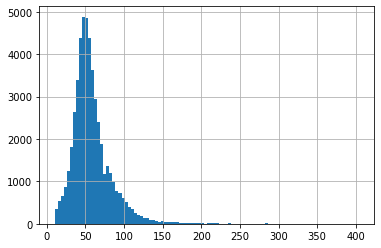

In [7]:
df_train.length.hist(bins=100)

length_std = df_train.length.std()
length_mean = df_train.length.mean()
print(f'Confidence interval: {length_mean:.2f} ± 3 * {length_std:.2f}, so interval is [0; {round(length_mean + 3 * length_std)}]')

df_train[['length']].describe()

Confidence interval: 3.84 ± 3 * 1.63, so interval is [1; 9]


,n_genres
count,50614.000000
mean,3.843759
std,1.625611
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,10.000000


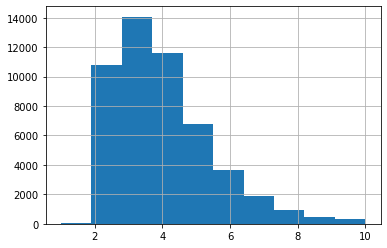

In [8]:
df_train['n_genres'] = df_train.tags.apply(lambda x: len(x.split(',')))
df_train['n_genres'].hist(bins=10)

length_std = df_train['n_genres'].std()
length_mean = df_train['n_genres'].mean()
print(f'Confidence interval: {length_mean:.2f} ± 3 * {length_std:.2f}, so interval is [1; {round(length_mean + 3 * length_std)}]')

df_train[['n_genres']].describe()

## Model Preparation

### Create Transformer Model

In [9]:
from torch.nn.utils.rnn import pad_sequence

# Custom Model for Genre Predictions
class Trackformer(nn.Module):
    def __init__(
        self,
        num_classes=NUM_TAGS,
        input_dim=768,
        hidden_dim=128,
        n_encoder_layers=1,
        n_decoder_layers=6,
        n_heads=4,
        dropout=0.1
    ):
        super().__init__()
        self.projector = nn.Linear(input_dim, hidden_dim)

        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=n_heads,
            num_encoder_layers=n_encoder_layers,
            num_decoder_layers=n_decoder_layers,
            dropout=dropout,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

        self.n_params = sum(p.numel() for p in self.parameters())

    def forward(self, embeds):
        # Counting only the first 138 seconds of each track (by default)
        x = [self.projector(x[:MAX_SECONDS]) for x in embeds]
        x = pad_sequence(x, batch_first=True, padding_value=0) # add zero-padding
        x = self.transformer(x, x[:, 0, :].unsqueeze(1)).squeeze(1)
        out = self.fc(x)
        return out

### Add Train/Evaluation/Predict Functions

In [10]:
def train_epoch(model, train_loader, val_loader, criterion, optimizer):
    model.train()

    for iteration, data in enumerate(train_loader):
        optimizer.zero_grad()
        embeds, target = data
        embeds = [x.to(CUDA_DEV) for x in embeds]
        target = target.to(CUDA_DEV).float()
        pred_logits = model(embeds).sigmoid().float()
        ce_loss = criterion(pred_logits, target)
        ce_loss.backward()
        optimizer.step()

        if iteration % 100 == 0:
            train_loss = ce_loss.item()
            val_loss, val_acc = evaluate_model(model, val_loader)
            if IS_WANDB:
                wandb.log({"batch": iteration + 1, "train_loss": train_loss, "val_loss": val_loss, "val_acc": val_acc})
            print(f'   {datetime.now()} batch {iteration + 1} train_loss {train_loss:.5f} val_loss {val_loss:.5f} val_acc {val_acc:.5f}')

In [11]:
import warnings
from sklearn.metrics import average_precision_score

def evaluate_model(model, val_loader):
    warnings.filterwarnings("ignore")
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for iteration, data in enumerate(val_loader):
            embeds, target = data
            embeds = [x.to(CUDA_DEV) for x in embeds]
            target = target.to(CUDA_DEV).float()
            pred_logits = model(embeds).sigmoid().float()

            y_pred, y_true = pred_logits.cpu().detach().numpy(), target.cpu().detach().numpy()
            val_acc += average_precision_score(y_true, y_pred, average='macro', pos_label=1, sample_weight=None)

            ce_loss = criterion(pred_logits, target)
            val_loss += ce_loss.item()

    warnings.filterwarnings("default")
    return val_loss / iteration, val_acc / iteration

In [12]:
def predict(model, loader):
    model.eval()
    track_idxs = []
    predictions = []
    with torch.no_grad():
        for data in loader:
            track_idx, embeds = data
            embeds = [x.to(CUDA_DEV) for x in embeds]
            pred_probs = model(embeds).sigmoid()
            predictions.append(pred_probs.cpu().numpy())
            track_idxs.append(track_idx.numpy())
    predictions = np.vstack(predictions)
    track_idxs = np.vstack(track_idxs).ravel()
    return track_idxs, predictions

### Import W&B (if needed)

In [13]:
if IS_WANDB:
    import wandb
    wandb.login()

def wandb_init_if_needed():
    if IS_WANDB:
        wandb.init(
            project="Trackformer",
            config={
                "architecture": "Transformer",
                "learning_rate": OPTIM_LR,
                "epochs": N_EPOCH,
            }
        )

In [18]:
# wandb.finish()

## Train 1 Fold

In [17]:
fold = 1 # Folds from 1 to 10 (by default)
fold_size = df_train.shape[0] // N_FOLDS

val_df = df_train[fold_size * (fold-1):fold_size * fold]
train_df = df_train.loc[~df_train.index.isin(range(fold_size * (fold - 1), fold_size * fold))]

test_dataset = TaggingDataset(df_test, True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_test)

train_dataset = TaggingDataset(train_df)
val_dataset = TaggingDataset(val_df)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [19]:
model = Trackformer()
criterion = nn.BCELoss()

print(f'Total params: {model.n_params:_}')

model = model.to(CUDA_DEV)
criterion = criterion.to(CUDA_DEV)
optimizer = torch.optim.AdamW(model.parameters(), lr=OPTIM_LR)

wandb_init_if_needed()
for epoch in tqdm(range(N_EPOCH)):
    train_epoch(model, train_dataloader, val_dataloader, criterion, optimizer)

Total params: 4_680_960


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

   2023-11-13 21:07:02.841561 batch 1 train_loss 0.72929 val_loss 0.61133 val_acc 0.04060
   2023-11-13 21:07:14.194396 batch 101 train_loss 0.09590 val_loss 0.09712 val_acc 0.05238
   2023-11-13 21:07:25.531234 batch 201 train_loss 0.07321 val_loss 0.07127 val_acc 0.05375
   2023-11-13 21:07:36.841067 batch 301 train_loss 0.06190 val_loss 0.06550 val_acc 0.07175
   2023-11-13 21:07:48.357905 batch 401 train_loss 0.05999 val_loss 0.06253 val_acc 0.08454
   2023-11-13 21:07:59.936738 batch 501 train_loss 0.06027 val_loss 0.06063 val_acc 0.10087
   2023-11-13 21:08:11.496572 batch 601 train_loss 0.05305 val_loss 0.05927 val_acc 0.11757
   2023-11-13 21:08:22.811407 batch 701 train_loss 0.05560 val_loss 0.05766 val_acc 0.12854


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:29<00:00, 89.11s/it]


### Make Single Submission

In [20]:
%%time
track_idxs, predictions = predict(model, test_dataloader)

CPU times: total: 7.97 s
Wall time: 7.95 s


In [21]:
predictions_df = pd.DataFrame([
    {'track': track, 'prediction': ','.join([str(p) for p in probs])}
    for track, probs in zip(track_idxs, predictions)
])

In [22]:
predictions_df.to_csv(f'pred_tformer_fold{fold}.csv', index=False)

In [23]:
predictions_df.head()

,track,prediction
0,17730,"0.37374988,0.20363799,0.2021929,0.3041287,0.03..."
1,32460,"0.29124525,0.3581382,0.22837844,0.1856402,0.02..."
2,11288,"0.14650339,0.22279377,0.18561621,0.23304635,0...."
3,18523,"0.54540426,0.13262658,0.28503522,0.11530596,0...."
4,71342,"0.14968708,0.05640894,0.11685478,0.29343122,0...."


## Train all 10 Folds

In [14]:
for fold in range(1, N_FOLDS + 1):
    print(f'FOLD-{fold}:')
    ### Get Fold
    fold_size = df_train.shape[0] // N_FOLDS

    val_df = df_train[fold_size * (fold-1):fold_size * fold]
    train_df = df_train.loc[~df_train.index.isin(range(fold_size * (fold - 1), fold_size * fold))]

    test_dataset = TaggingDataset(df_test, True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_test)

    train_dataset = TaggingDataset(train_df)
    val_dataset = TaggingDataset(val_df)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    ### /Get Fold

    ### Init new W&B session if needed:
    wandb_init_if_needed()

    ### Train Model
    model = Trackformer()
    criterion = nn.BCELoss()

    print(f'Total params: {model.n_params:_}')

    model = model.to(CUDA_DEV)
    criterion = criterion.to(CUDA_DEV)
    optimizer = torch.optim.AdamW(model.parameters(), lr=OPTIM_LR)

    for epoch in tqdm(range(N_EPOCH)):
        train_epoch(model, train_dataloader, val_dataloader, criterion, optimizer)
    ### /Train Model

    ### Get Prediction
    track_idxs, predictions = predict(model, test_dataloader)

    predictions_df = pd.DataFrame([
        {'track': track, 'prediction': ','.join([str(p) for p in probs])}
        for track, probs in zip(track_idxs, predictions)
    ])
    ### /Get Prediction

    ### Save predictions of current fold
    predictions_df.to_csv(f'pred_tformer_fold{fold}.csv', index=False)
    print(f'Fold-{fold} saved!\n\n')

### Bagging Submission

In [15]:
preds = []
for i in tqdm(range(1, N_FOLDS + 1)):
    pred = pd.read_csv(f'pred_tformer_fold{i}.csv')['prediction'].apply(lambda x: list(map(float, x.split(','))) ).values
    pred = np.array([np.array(x) for x in pred])
    preds.append(pred)
preds = np.array(preds)

In [16]:
predictions = preds.mean(axis=0)
predictions

In [54]:
predictions_df = pd.DataFrame([
    {'track': track, 'prediction': ','.join([str(p) for p in probs])}
    for track, probs in zip(df_test.track.values, predictions)
])

predictions_df.to_csv(f'pred_tformer_fold_1_{N_FOLDS}.csv', index=False)
predictions_df.head()

,track,prediction
0,17730,"0.025683811500000004,0.04249316646,0.121365329..."
1,32460,"0.054375936999999985,0.4695480709999999,0.2681..."
2,11288,"0.115668747,0.413396596,0.23798349599999996,0...."
3,18523,"0.658433986,0.02621826585,0.1576727775,0.38235..."
4,71342,"0.01329453447,0.00532173159,0.0136098291699999..."
